## Test from Claude 100k dataset Final

In [6]:
# Enhanced MovieLens Matrix Factorization with Full Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle
import warnings
warnings.filterwarnings('ignore')

DATA_FOLDER = 'dataset/'

# Load data
ratings_df = pd.read_table(f"{DATA_FOLDER}ratings.csv", sep=',')
movies_df = pd.read_table(f"{DATA_FOLDER}movies.csv", sep=',')


print(f"Original ratings shape: {ratings_df.shape}")
print(f"Original movies shape: {movies_df.shape}")

Original ratings shape: (100836, 4)
Original movies shape: (9742, 3)


## 1. Genre Analysis of Full Dataset

In [ ]:

print("\n=== GENRE ANALYSIS ===")

# Extract all unique genres
all_genres = set()
for genres_str in movies_df.genres:
    genres_list = genres_str.split('|')
    all_genres.update(genres_list)

print(f"Unique genres ({len(all_genres)}):")
for genre in sorted(all_genres):
    count = movies_df[movies_df.genres.str.contains(genre)].shape[0]
    print(f"  {genre}: {count} movies")


=== GENRE ANALYSIS ===
Unique genres (20):
  (no genres listed): 34 movies
  Action: 1828 movies
  Adventure: 1263 movies
  Animation: 611 movies
  Children: 664 movies
  Comedy: 3756 movies
  Crime: 1199 movies
  Documentary: 440 movies
  Drama: 4361 movies
  Fantasy: 779 movies
  Film-Noir: 87 movies
  Horror: 978 movies
  IMAX: 158 movies
  Musical: 334 movies
  Mystery: 573 movies
  Romance: 1596 movies
  Sci-Fi: 980 movies
  Thriller: 1894 movies
  War: 382 movies
  Western: 167 movies


## 2. Creating Sparse Matrix

In [ ]:
selected_df = ratings_df.copy()
print(f"\nUsing full dataset: {selected_df.shape[0]} ratings")

# Create sparse matrix
_, inverse_user = np.unique(selected_df.userId, return_inverse=True)
unique_users = np.unique(selected_df.userId)  # Create unique_users here
unique_movies, inverse_movie = np.unique(selected_df.movieId, return_inverse=True)

print(f"Matrix dimensions: {len(unique_users)} users × {len(unique_movies)} movies")

# Use actual ratings instead of binary (>=4)
mat = coo_matrix((selected_df.rating, (inverse_user, inverse_movie)))


Using full dataset: 100836 ratings
Matrix dimensions: 610 users × 9724 movies


## 3. Creating Train and Test Sets

In [ ]:

def create_train_test_split(mat, test_size=0.2, random_state=42):
    """Split sparse matrix into train/test sets"""
    np.random.seed(random_state)
    
    # Get non-zero entries
    row, col = mat.nonzero()
    data = mat.data
    
    # Random split
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    
    split_idx = int(len(indices) * (1 - test_size))
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    # Create train matrix
    train_mat = coo_matrix(
        (data[train_indices], (row[train_indices], col[train_indices])),
        shape=mat.shape
    )
    
    # Store test data for evaluation
    test_data = {
        'users': row[test_indices],
        'movies': col[test_indices], 
        'ratings': data[test_indices]
    }
    
    return train_mat, test_data

train_mat, test_data = create_train_test_split(mat)
print(f"Train entries: {train_mat.nnz}, Test entries: {len(test_data['ratings'])}")

Train entries: 80668, Test entries: 20168


## 4: Find optimal number of components with better selection

In [ ]:

def evaluate_components(train_mat, test_data, max_components=50, step=5):
    """Evaluate different numbers of components"""
    components_range = range(2, min(max_components, min(train_mat.shape)), step)
    results = []
    
    print("\n=== COMPONENT OPTIMIZATION ===")
    print("Components | Train RMSE | Test RMSE | Explained Variance")
    print("-" * 55)
    
    for n_comp in components_range:
        # Fit SVD
        model = TruncatedSVD(n_components=n_comp, random_state=42)
        U = model.fit_transform(train_mat)
        V = model.components_
        
        # Reconstruct ratings
        reconstructed = U @ V
        
        # Train RMSE (on non-zero entries only)
        train_pred = reconstructed[train_mat.nonzero()]
        train_actual = train_mat.data
        train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))
        
        # Test RMSE
        test_pred = reconstructed[test_data['users'], test_data['movies']]
        test_rmse = np.sqrt(mean_squared_error(test_data['ratings'], test_pred))
        
        # Explained variance ratio
        explained_var = model.explained_variance_ratio_.sum()
        
        results.append({
            'n_components': n_comp,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'explained_variance': explained_var,
            'model': model,
            'U': U,
            'V': V
        })
        
        print(f"{n_comp:9d} | {train_rmse:10.4f} | {test_rmse:9.4f} | {explained_var:16.4f}")
    
    return results

def find_optimal_components(results, tolerance=0.005):
    """Find optimal components using early stopping with tolerance"""
    # Sort by number of components
    sorted_results = sorted(results, key=lambda x: x['n_components'])
    
    min_test_rmse = min(r['test_rmse'] for r in sorted_results)
    
    # Find first model within tolerance of minimum
    for result in sorted_results:
        if result['test_rmse'] <= min_test_rmse + tolerance:
            optimal_result = result
            break
    
    print(f"\n=== OPTIMAL MODEL SELECTION ===")
    print(f"Minimum test RMSE: {min_test_rmse:.4f}")
    print(f"Selected model (within {tolerance} tolerance): {optimal_result['n_components']} components")
    print(f"Selected test RMSE: {optimal_result['test_rmse']:.4f}")
    print(f"Difference from minimum: {optimal_result['test_rmse'] - min_test_rmse:.4f}")
    
    return optimal_result

# Run evaluation with finer granularity
results_coarse = evaluate_components(train_mat, test_data, max_components=30, step=3)

# Find approximate range for fine search
min_rmse_result = min(results_coarse, key=lambda x: x['test_rmse'])
search_center = min_rmse_result['n_components']
print(f"\nCoarse search minimum at {search_center} components")

# Fine search around the minimum
print(f"\n=== FINE SEARCH AROUND {search_center} ===")
fine_range = range(max(2, search_center-6), min(search_center+7, min(train_mat.shape)), 1)
results_fine = evaluate_components(train_mat, test_data, max_components=max(fine_range)+1, step=1)
results_fine = [r for r in results_fine if r['n_components'] in fine_range]

# Combine results for plotting (remove duplicates)
all_results = {r['n_components']: r for r in results_coarse + results_fine}.values()
all_results = list(all_results)

# Find optimal model using early stopping
best_result = find_optimal_components(all_results, tolerance=0.005)


=== COMPONENT OPTIMIZATION ===
Components | Train RMSE | Test RMSE | Explained Variance
-------------------------------------------------------
        2 |     3.0127 |    3.0643 |           0.1395
        5 |     2.8416 |    2.9723 |           0.1992
        8 |     2.7415 |    2.9566 |           0.2414
       11 |     2.6663 |    2.9617 |           0.2736
       14 |     2.6046 |    2.9821 |           0.3017
       17 |     2.5493 |    2.9966 |           0.3267
       20 |     2.5018 |    3.0163 |           0.3489
       23 |     2.4565 |    3.0456 |           0.3693
       26 |     2.4120 |    3.0667 |           0.3886
       29 |     2.3691 |    3.0812 |           0.4062

Coarse search minimum at 8 components

=== FINE SEARCH AROUND 8 ===

=== COMPONENT OPTIMIZATION ===
Components | Train RMSE | Test RMSE | Explained Variance
-------------------------------------------------------
        2 |     3.0127 |    3.0643 |           0.1395
        3 |     2.9412 |    3.0160 |           

## 5. Saving the best model with pickle

In [ ]:

def save_best_model(best_result, movies_df, unique_users, filename='best_mf_model.pkl'):
    """Save the best model and metadata"""
    model_data = {
        'model': best_result['model'],
        'U': best_result['U'], 
        'V': best_result['V'],
        'n_components': best_result['n_components'],
        'test_rmse': best_result['test_rmse'],
        'explained_variance': best_result['explained_variance'],
        'unique_movies': unique_movies,
        'unique_users': unique_users,
        'movies_df': movies_df
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(model_data, f)
    
    print(f"Model saved to {filename}")
    return model_data

saved_model = save_best_model(best_result, movies_df, unique_users)

Model saved to best_mf_model.pkl


## 6: Enhanced visualization with better model selection insights

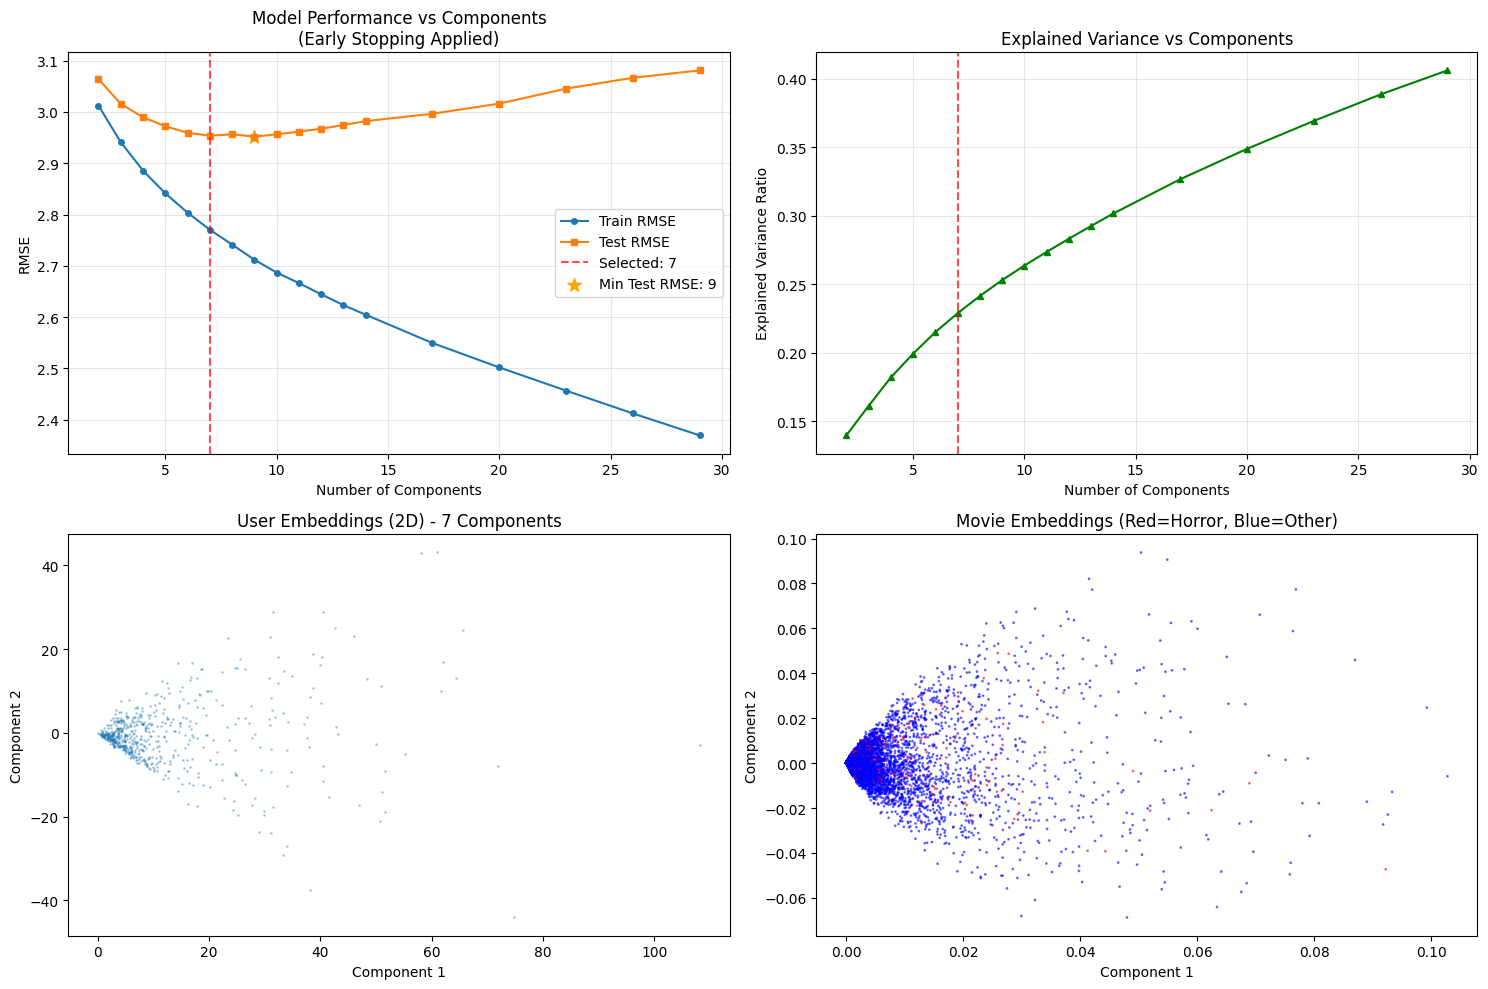

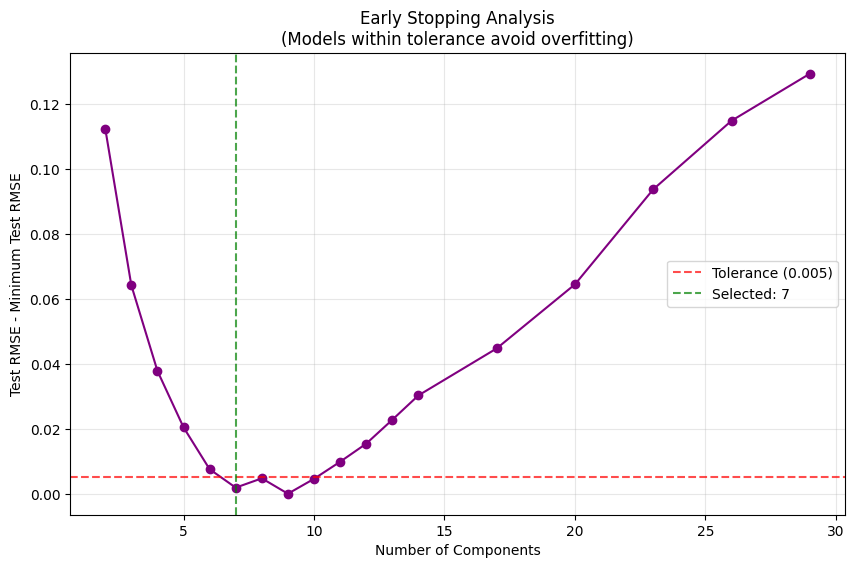

In [ ]:

def plot_results(all_results, best_result):
    """Plot optimization results and embeddings"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Sort results by components for plotting
    sorted_results = sorted(all_results, key=lambda x: x['n_components'])
    
    # Plot 1: RMSE vs Components
    components = [r['n_components'] for r in sorted_results]
    train_rmse = [r['train_rmse'] for r in sorted_results]
    test_rmse = [r['test_rmse'] for r in sorted_results]
    
    axes[0,0].plot(components, train_rmse, 'o-', label='Train RMSE', markersize=4)
    axes[0,0].plot(components, test_rmse, 's-', label='Test RMSE', markersize=4)
    
    # Highlight optimal point
    axes[0,0].axvline(best_result['n_components'], color='red', linestyle='--', alpha=0.7, 
                     label=f'Selected: {best_result["n_components"]}')
    
    # Mark minimum test RMSE point
    min_test_idx = np.argmin(test_rmse)
    axes[0,0].scatter(components[min_test_idx], test_rmse[min_test_idx], 
                     color='orange', s=100, marker='*', label=f'Min Test RMSE: {components[min_test_idx]}')
    
    axes[0,0].set_xlabel('Number of Components')
    axes[0,0].set_ylabel('RMSE')
    axes[0,0].set_title('Model Performance vs Components\n(Early Stopping Applied)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Explained Variance
    explained_var = [r['explained_variance'] for r in sorted_results]
    axes[0,1].plot(components, explained_var, 'g^-', markersize=4)
    axes[0,1].axvline(best_result['n_components'], color='red', linestyle='--', alpha=0.7)
    axes[0,1].set_xlabel('Number of Components')
    axes[0,1].set_ylabel('Explained Variance Ratio')
    axes[0,1].set_title('Explained Variance vs Components')
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: User embeddings (first 2 components)
    U = best_result['U']
    axes[1,0].scatter(U[:,0], U[:,1], alpha=0.3, s=1)
    axes[1,0].set_xlabel('Component 1')
    axes[1,0].set_ylabel('Component 2')
    axes[1,0].set_title(f'User Embeddings (2D) - {best_result["n_components"]} Components')
    
    # Plot 4: Movie embeddings colored by genre
    V = best_result['V']
    # Color by horror movies as example
    horror_ids = movies_df[movies_df.genres.str.contains("Horror")].movieId.values
    is_horror = [movie_id in horror_ids for movie_id in unique_movies]
    
    colors = ['red' if horror else 'blue' for horror in is_horror]
    axes[1,1].scatter(V[0,:], V[1,:], alpha=0.5, c=colors, s=1)
    axes[1,1].set_xlabel('Component 1')
    axes[1,1].set_ylabel('Component 2') 
    axes[1,1].set_title('Movie Embeddings (Red=Horror, Blue=Other)')
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis plot
    fig2, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Plot test RMSE difference from minimum
    min_test_rmse = min(test_rmse)
    rmse_diff = [rmse - min_test_rmse for rmse in test_rmse]
    
    ax.plot(components, rmse_diff, 'o-', color='purple', markersize=6)
    ax.axhline(0.005, color='red', linestyle='--', alpha=0.7, label='Tolerance (0.005)')
    ax.axvline(best_result['n_components'], color='green', linestyle='--', alpha=0.7, 
              label=f'Selected: {best_result["n_components"]}')
    
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Test RMSE - Minimum Test RMSE')
    ax.set_title('Early Stopping Analysis\n(Models within tolerance avoid overfitting)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()

plot_results(all_results, best_result)

## 7. Load and use saved model with user analysis

In [ ]:
def load_and_predict(filename='best_mf_model.pkl', user_idx=0, top_k=10):
    """Load saved model and make predictions"""
    with open(filename, 'rb') as f:
        model_data = pickle.load(f)
    
    U = model_data['U']
    V = model_data['V'] 
    unique_movies = model_data['unique_movies']
    movies_df = model_data['movies_df']
    unique_users = model_data['unique_users']
    
    # Get actual user ID
    actual_user_id = unique_users[user_idx]
    
    # Predict ratings for a user
    user_ratings = U[user_idx] @ V
    
    # Get top recommendations
    top_indices = np.argsort(user_ratings)[-top_k:][::-1]
    top_movie_ids = unique_movies[top_indices]
    top_scores = user_ratings[top_indices]
    
    # Get movie titles
    recommendations = []
    for movie_id, score in zip(top_movie_ids, top_scores):
        title = movies_df[movies_df.movieId == movie_id].title.iloc[0]
        genres = movies_df[movies_df.movieId == movie_id].genres.iloc[0]
        recommendations.append({
            'movie_id': movie_id, 
            'title': title, 
            'genres': genres,
            'predicted_rating': score
        })
    
    return actual_user_id, recommendations

def analyze_user_preferences(user_id, selected_df, movies_df, top_k=5):
    """Analyze a user's historical preferences"""
    user_ratings = selected_df[selected_df.userId == user_id].copy()
    
    if len(user_ratings) == 0:
        return None
    
    # Get user's top rated movies
    top_rated = user_ratings.nlargest(top_k, 'rating')
    
    # Get genre preferences
    all_genres = []
    for _, row in top_rated.iterrows():
        movie_genres = movies_df[movies_df.movieId == row.movieId].genres.iloc[0]
        all_genres.extend(movie_genres.split('|'))
    
    # Count genre frequency
    from collections import Counter
    genre_counts = Counter(all_genres)
    
    user_info = {
        'user_id': user_id,
        'total_ratings': len(user_ratings),
        'avg_rating': user_ratings.rating.mean(),
        'top_movies': [],
        'favorite_genres': genre_counts.most_common(3)
    }
    
    for _, row in top_rated.iterrows():
        movie_info = movies_df[movies_df.movieId == row.movieId].iloc[0]
        user_info['top_movies'].append({
            'title': movie_info.title,
            'genres': movie_info.genres,
            'rating': row.rating
        })
    
    return user_info

def get_user_recommendations_with_analysis(user_idx=None, filename='best_mf_model.pkl'):
    """Get recommendations with user analysis"""
    
    # If no user specified, pick a random active user
    if user_idx is None:
        # Find users with many ratings
        user_rating_counts = selected_df.groupby('userId').size()
        active_users = user_rating_counts[user_rating_counts >= 20]  # Users with 20+ ratings
        
        if len(active_users) > 0:
            # Pick a random active user
            selected_user_id = np.random.choice(active_users.index)
            # Find their index in the unique users array
            user_idx = list(np.unique(selected_df.userId)).index(selected_user_id)
        else:
            user_idx = 10  # Fallback
    
    # Get recommendations
    actual_user_id, recommendations = load_and_predict(filename, user_idx, top_k=10)
    
    # Analyze user's historical preferences
    user_info = analyze_user_preferences(actual_user_id, selected_df, movies_df)
    
    return actual_user_id, user_info, recommendations

# Update the model saving to include unique_users
def save_best_model(best_result, movies_df, unique_users, filename='best_mf_model.pkl'):
    """Save the best model and metadata"""
    model_data = {
        'model': best_result['model'],
        'U': best_result['U'], 
        'V': best_result['V'],
        'n_components': best_result['n_components'],
        'test_rmse': best_result['test_rmse'],
        'explained_variance': best_result['explained_variance'],
        'unique_movies': unique_movies,
        'unique_users': unique_users,  # Add this
        'movies_df': movies_df
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(model_data, f)
    
    print(f"Model saved to {filename}")
    return model_data


In [15]:
# Create unique users array (add after creating the matrix)
_, inverse_user = np.unique(selected_df.userId, return_inverse=True)
unique_users = np.unique(selected_df.userId)  # Add this line

# Update model saving call
saved_model = save_best_model(best_result, movies_df, unique_users)

# Enhanced prediction example
print(f"\n=== USER RECOMMENDATION ANALYSIS ===")
user_id, user_info, recommendations = get_user_recommendations_with_analysis()

if user_info:
    print(f"\nUSER PROFILE:")
    print(f"User ID: {user_info['user_id']}")
    print(f"Total ratings given: {user_info['total_ratings']}")
    print(f"Average rating: {user_info['avg_rating']:.2f}")
    
    print(f"\nUSER'S TOP RATED MOVIES:")
    for i, movie in enumerate(user_info['top_movies'], 1):
        print(f"{i}. {movie['title']} (Rating: {movie['rating']}) - {movie['genres']}")
    
    print(f"\nFAVORITE GENRES:")
    for genre, count in user_info['favorite_genres']:
        print(f"• {genre}: appears in {count} of their top movies")

print(f"\nMODEL RECOMMENDATIONS FOR USER {user_id}:")
for i, rec in enumerate(recommendations[:5], 1):
    print(f"{i}. {rec['title']} (Score: {rec['predicted_rating']:.2f})")
    print(f"   Genres: {rec['genres']}")

print(f"\nModel successfully saved and loaded!")
print(f"Final model uses {best_result['n_components']} components with RMSE: {best_result['test_rmse']:.4f}")


Model saved to best_mf_model.pkl

=== USER RECOMMENDATION ANALYSIS ===

USER PROFILE:
User ID: 260
Total ratings given: 152
Average rating: 3.76

USER'S TOP RATED MOVIES:
1. Usual Suspects, The (1995) (Rating: 5.0) - Crime|Mystery|Thriller
2. Taxi Driver (1976) (Rating: 5.0) - Crime|Drama|Thriller
3. Fargo (1996) (Rating: 5.0) - Comedy|Crime|Drama|Thriller
4. Wallace & Gromit: The Best of Aardman Animation (1996) (Rating: 5.0) - Adventure|Animation|Comedy
5. Reservoir Dogs (1992) (Rating: 5.0) - Crime|Mystery|Thriller

FAVORITE GENRES:
• Crime: appears in 4 of their top movies
• Thriller: appears in 4 of their top movies
• Mystery: appears in 2 of their top movies

MODEL RECOMMENDATIONS FOR USER 260:
1. American Beauty (1999) (Score: 1.69)
   Genres: Drama|Romance
2. Fight Club (1999) (Score: 1.54)
   Genres: Action|Crime|Drama|Thriller
3. Fargo (1996) (Score: 1.46)
   Genres: Comedy|Crime|Drama|Thriller
4. Usual Suspects, The (1995) (Score: 1.42)
   Genres: Crime|Mystery|Thriller
5. P

## 8: Cosine similarity analysis for users and items

In [ ]:

def compute_similarities(U, V, unique_users, unique_movies, movies_df, top_k=10):
    """Compute cosine similarities between users and between movies"""
    from sklearn.metrics.pairwise import cosine_similarity
    
    print(f"\n=== SIMILARITY ANALYSIS ===")
    
    # User-User similarity
    print("Computing user-user similarities...")
    user_similarity = cosine_similarity(U)
    print(f"User similarity matrix shape: {user_similarity.shape}")
    
    # Item-Item similarity  
    print("Computing movie-movie similarities...")
    movie_similarity = cosine_similarity(V.T)  # Transpose V since movies are columns
    print(f"Movie similarity matrix shape: {movie_similarity.shape}")
    
    return user_similarity, movie_similarity

def find_similar_users(user_id, user_similarity, unique_users, selected_df, top_k=5):
    """Find most similar users to a given user"""
    if user_id not in unique_users:
        print(f"User {user_id} not found in dataset")
        return []
    
    user_idx = list(unique_users).index(user_id)
    
    # Get similarity scores (exclude self)
    similarities = user_similarity[user_idx].copy()
    similarities[user_idx] = -1  # Remove self-similarity
    
    # Get top similar users
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    
    similar_users = []
    for idx in top_indices:
        similar_user_id = unique_users[idx]
        similarity_score = similarities[idx]
        
        # Get user stats
        user_ratings = selected_df[selected_df.userId == similar_user_id]
        
        similar_users.append({
            'user_id': similar_user_id,
            'similarity': similarity_score,
            'total_ratings': len(user_ratings),
            'avg_rating': user_ratings.rating.mean() if len(user_ratings) > 0 else 0
        })
    
    return similar_users

def find_similar_movies(movie_id, movie_similarity, unique_movies, movies_df, top_k=5):
    """Find most similar movies to a given movie"""
    if movie_id not in unique_movies:
        print(f"Movie {movie_id} not found in dataset")
        return []
    
    movie_idx = list(unique_movies).index(movie_id)
    
    # Get similarity scores (exclude self)
    similarities = movie_similarity[movie_idx].copy()
    similarities[movie_idx] = -1  # Remove self-similarity
    
    # Get top similar movies
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    
    similar_movies = []
    for idx in top_indices:
        similar_movie_id = unique_movies[idx]
        similarity_score = similarities[idx]
        
        # Get movie info
        movie_info = movies_df[movies_df.movieId == similar_movie_id].iloc[0]
        
        similar_movies.append({
            'movie_id': similar_movie_id,
            'title': movie_info.title,
            'genres': movie_info.genres,
            'similarity': similarity_score
        })
    
    return similar_movies

def analyze_similarity_patterns(user_similarity, movie_similarity):
    """Analyze overall similarity patterns"""
    print(f"\nSIMILARITY STATISTICS:")
    
    # User similarity stats (exclude diagonal)
    user_sim_flat = user_similarity[np.triu_indices_from(user_similarity, k=1)]
    print(f"User-User Similarities:")
    print(f"  Mean: {user_sim_flat.mean():.4f}")
    print(f"  Std:  {user_sim_flat.std():.4f}")
    print(f"  Max:  {user_sim_flat.max():.4f}")
    print(f"  Min:  {user_sim_flat.min():.4f}")
    
    # Movie similarity stats (exclude diagonal)
    movie_sim_flat = movie_similarity[np.triu_indices_from(movie_similarity, k=1)]
    print(f"\nMovie-Movie Similarities:")
    print(f"  Mean: {movie_sim_flat.mean():.4f}")
    print(f"  Std:  {movie_sim_flat.std():.4f}")
    print(f"  Max:  {movie_sim_flat.max():.4f}")
    print(f"  Min:  {movie_sim_flat.min():.4f}")
    
    return user_sim_flat, movie_sim_flat

def similarity_based_recommendations(user_id, user_similarity, unique_users, selected_df, 
                                   unique_movies, movies_df, top_k=5):
    """Generate recommendations based on user similarity (collaborative filtering)"""
    if user_id not in unique_users:
        return []
    
    user_idx = list(unique_users).index(user_id)
    
    # Get user's rated movies
    user_movies = set(selected_df[selected_df.userId == user_id].movieId.values)
    
    # Find similar users
    similarities = user_similarity[user_idx].copy()
    similarities[user_idx] = 0  # Remove self
    
    # Weight ratings by user similarity
    recommendations = {}
    
    for similar_user_idx, similarity_score in enumerate(similarities):
        if similarity_score > 0.1:  # Only consider reasonably similar users
            similar_user_id = unique_users[similar_user_idx]
            similar_user_ratings = selected_df[selected_df.userId == similar_user_id]
            
            for _, rating_row in similar_user_ratings.iterrows():
                movie_id = rating_row.movieId
                rating = rating_row.rating
                
                # Skip movies user has already rated
                if movie_id not in user_movies and movie_id in unique_movies:
                    if movie_id not in recommendations:
                        recommendations[movie_id] = {'weighted_sum': 0, 'similarity_sum': 0}
                    
                    recommendations[movie_id]['weighted_sum'] += similarity_score * rating
                    recommendations[movie_id]['similarity_sum'] += abs(similarity_score)
    
    # Calculate predicted ratings
    predicted_ratings = []
    for movie_id, data in recommendations.items():
        if data['similarity_sum'] > 0:
            predicted_rating = data['weighted_sum'] / data['similarity_sum']
            
            movie_info = movies_df[movies_df.movieId == movie_id].iloc[0]
            predicted_ratings.append({
                'movie_id': movie_id,
                'title': movie_info.title,
                'genres': movie_info.genres,
                'predicted_rating': predicted_rating
            })
    
    # Sort by predicted rating
    predicted_ratings.sort(key=lambda x: x['predicted_rating'], reverse=True)
    
    return predicted_ratings[:top_k]

In [17]:
# Compute similarities
user_similarity, movie_similarity = compute_similarities(
    best_result['U'], best_result['V'], unique_users, unique_movies, movies_df
)

# Analyze similarity patterns
user_sim_stats, movie_sim_stats = analyze_similarity_patterns(user_similarity, movie_similarity)

# Example similarity analysis for the sample user
print(f"\n=== SIMILARITY-BASED ANALYSIS FOR USER {user_id} ===")

# Find similar users
similar_users = find_similar_users(user_id, user_similarity, unique_users, selected_df)
print(f"\nMOST SIMILAR USERS:")
for i, sim_user in enumerate(similar_users, 1):
    print(f"{i}. User {sim_user['user_id']} (Similarity: {sim_user['similarity']:.3f})")
    print(f"   {sim_user['total_ratings']} ratings, avg: {sim_user['avg_rating']:.2f}")

# Get a movie the user liked for similarity analysis
if user_info and user_info['top_movies']:
    sample_movie_title = user_info['top_movies'][0]['title']
    # Find the movie ID
    sample_movie_row = movies_df[movies_df.title == sample_movie_title]
    if not sample_movie_row.empty:
        sample_movie_id = sample_movie_row.iloc[0].movieId
        
        if sample_movie_id in unique_movies:
            similar_movies = find_similar_movies(sample_movie_id, movie_similarity, 
                                               unique_movies, movies_df)
            print(f"\nMOVIES SIMILAR TO '{sample_movie_title}':")
            for i, sim_movie in enumerate(similar_movies, 1):
                print(f"{i}. {sim_movie['title']} (Similarity: {sim_movie['similarity']:.3f})")
                print(f"   Genres: {sim_movie['genres']}")

# Collaborative filtering recommendations
collab_recs = similarity_based_recommendations(user_id, user_similarity, unique_users, 
                                             selected_df, unique_movies, movies_df)
print(f"\nCOLLABORATIVE FILTERING RECOMMENDATIONS:")
print("(Based on similar users' preferences)")
for i, rec in enumerate(collab_recs[:5], 1):
    print(f"{i}. {rec['title']} (Score: {rec['predicted_rating']:.2f})")
    print(f"   Genres: {rec['genres']}")

print(f"\nCOMPARISON:")
print("• Matrix Factorization: Discovers latent factors in user-movie interactions")
print("• Collaborative Filtering: Uses direct user-user similarities")
print("• Both methods can provide different but complementary recommendations")


=== SIMILARITY ANALYSIS ===
Computing user-user similarities...
User similarity matrix shape: (610, 610)
Computing movie-movie similarities...
Movie similarity matrix shape: (9724, 9724)

SIMILARITY STATISTICS:
User-User Similarities:
  Mean: 0.5280
  Std:  0.2628
  Max:  0.9995
  Min:  -0.4462

Movie-Movie Similarities:
  Mean: 0.0911
  Std:  0.3745
  Max:  1.0000
  Min:  -0.9616

=== SIMILARITY-BASED ANALYSIS FOR USER 260 ===

MOST SIMILAR USERS:
1. User 324 (Similarity: 0.967)
   21 ratings, avg: 3.14
2. User 346 (Similarity: 0.962)
   164 ratings, avg: 3.68
3. User 440 (Similarity: 0.955)
   33 ratings, avg: 3.89
4. User 23 (Similarity: 0.936)
   121 ratings, avg: 3.65
5. User 74 (Similarity: 0.931)
   177 ratings, avg: 4.27

MOVIES SIMILAR TO 'Usual Suspects, The (1995)':
1. Léon: The Professional (a.k.a. The Professional) (Léon) (1994) (Similarity: 0.962)
   Genres: Action|Crime|Drama|Thriller
2. Pulp Fiction (1994) (Similarity: 0.931)
   Genres: Comedy|Crime|Drama|Thriller
3. C